# ANALYSIS OF REVIEW SEMANTICS (<u>REVIEW ANALYTICS</u>)

## <u>1. Preliminaries</u>

### 1.1 Importing packages

In [1]:
#Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import re

G:\PROGRAMOWANIE\anaconda\program\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
G:\PROGRAMOWANIE\anaconda\program\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### 1.2 Loading data

In [2]:
#Load the data
df_products = pd.read_csv('data/products.csv')
df_categories = pd.read_csv('data/product_category_name_translation.csv')
df_order_items = pd.read_csv('data/order_items.csv')
df_orders = pd.read_csv('data/orders.csv')
df_reviews = pd.read_csv('data/order_reviews.csv')
df_sellers = pd.read_csv('data/sellers.csv')

## <u>2. Correlation between review score and whether a text comment was left</u>

### 2.1 Data preparation

In [3]:
#Initial data processing
df_corr = df_reviews.drop(['review_id', 'review_comment_title', 'review_creation_date', 'review_answer_timestamp'], axis=1)
df_corr['has_comment'] = df_corr['review_comment_message'].notna().astype(int)

print('\nINITIAL DATA PROCESSING TABLE')
df_corr.head()


INITIAL DATA PROCESSING TABLE


,order_id,review_score,review_comment_message,has_comment
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,0
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,0
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,1


### 2.2 Processing data and performing calculations

In [4]:
#Aggregate data
corr_data = (
    df_corr
    .groupby('review_score')['has_comment']
    .agg(['count', 'sum'])
    .assign(has_comment_perc=lambda x: (x['sum'] / x['count']),
            no_comment=lambda x: x['count'] - x['sum'],
            no_comment_perc = lambda x: (x['no_comment'] / x['count'])
           )
    .rename(columns={'count': 'count_all', 'sum': 'has_comment'})
    .reset_index()
)

#Calculate the correlation
correlation = corr_data['review_score'].corr(corr_data['has_comment_perc'])

#Format percentage columns
corr_data['has_comment_perc'] = corr_data['has_comment_perc'].apply(lambda x: f"{x*100:.2f}%")
corr_data['no_comment_perc'] = corr_data['no_comment_perc'].apply(lambda x: f"{x*100:.2f}%")

### 2.3 Data visualization


Correlation between review_score and has_comment: -0.93



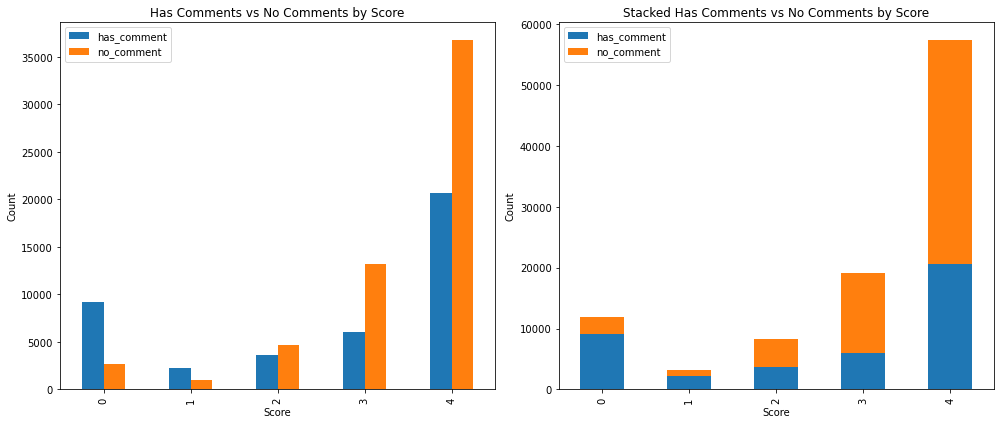


DATA CORRELATION TABLE


,count_all,has_comment,has_comment_perc,no_comment,no_comment_perc
review_score,,,,,
1,11858,9179,77.41%,2679,22.59%
2,3235,2229,68.90%,1006,31.10%
3,8287,3665,44.23%,4622,55.77%
4,19200,6034,31.43%,13166,68.57%
5,57420,20646,35.96%,36774,64.04%


In [5]:
#Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Bar plot
corr_data[['has_comment', 'no_comment']].plot(kind='bar', stacked=False, ax=axes[0])
axes[0].set_title('Has Comments vs No Comments by Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Count')

#Stacked bar plot
corr_data[['has_comment', 'no_comment']].plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Stacked Has Comments vs No Comments by Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Count')

#Display the results
print(f'\nCorrelation between review_score and has_comment: {correlation:.2f}\n')
plt.tight_layout()
plt.show()
print('\nDATA CORRELATION TABLE')
display(corr_data.set_index('review_score'))

### 2.4 Conclusions

It can be observed that there is a <b>strong negative correlation</b> between the review score and whether a text review was left. This means that the lower the score given by a user, the higher the chance he or she will leave a comment as well.

## <u>3. Products with best and worst reviews</u>

### 3.1 Data preparation

In [6]:
#Join the dataframes
merged_products = pd.merge(df_products, df_order_items, on='product_id')
merged_products = pd.merge(merged_products, df_reviews, on='order_id')

print('\nMERGED TABLE')
merged_products.head()


MERGED TABLE


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,...,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,...,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,d71da8fd8c6e3adef26be965f065b8a1,5,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,...,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,19866247db89845ef558ef19a6c26fcd,5,NaN,Excelente apontador! Em 3 segundos uma ponta p...,2018-02-17 00:00:00,2018-02-18 23:24:14
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,...,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,32921b4e09c9a19d61fe46ce04231b84,5,NaN,NaN,2018-07-14 00:00:00,2018-07-16 16:20:04
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,143d00a4f2dde4e0364ee1821577adb3,...,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,70949d129965fb1ee32aaccec720a19e,1,produto divergente,modelo comprado: travesseiro memoria carinho B...,2018-08-07 00:00:00,2018-08-08 11:53:04
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,86cafb8794cb99a9b1b77fc8e48fbbbb,...,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,74c9c7d0bc153bbbc92e4c1597b8ba55,5,NaN,NaN,2018-04-17 00:00:00,2018-04-18 04:29:47


### 3.2 Data analysis and results

In [7]:
#Set variables 
min_scores_per_product = 50 #minumum count of scores per product to be considered
n_display_product = 5 #number of top/bottom results displayed 

#Aggregate data for best and worst products
best_products = (
    merged_products
    .groupby(['product_id'])
    .agg(avg_score=('review_score', 'mean'), review_count=('review_score', 'count'))
    .loc[lambda x: x['review_count'] >= min_scores_per_product]
    .sort_values(by='avg_score', ascending=False)
)

worst_products = best_products.sort_values(by='avg_score', ascending=True)

#Display the results
print('\nBEST PRODUCTS')
display(best_products.head(n_display_product))
print('\nWORST PRODUCTS')
display(worst_products.head(n_display_product))


BEST PRODUCTS


,avg_score,review_count
product_id,,
73326828aa5efe1ba096223de496f596,4.833333,54
6a8631b72a2f8729b91514db87e771c0,4.709677,62
fbc1488c1a1e72ba175f53ab29a248e8,4.620690,58
5f504b3a1c75b73d6151be81eb05bdc9,4.555556,63
f7a17d2c51d9df89a4f1711c4ac17f33,4.546875,64



WORST PRODUCTS


,avg_score,review_count
product_id,,
89b121bee266dcd25688a1ba72eefb61,2.382353,68
b5e13c9a353102f79c6206ff5cb61a50,2.890110,91
362b773250263786dd58670d2df42c3b,2.917808,73
3eef0cb94ba82de806bb30ab743c7655,3.186441,59
b114bf337c0626166abe574eee9e3f32,3.222222,54


## <u>4. Sellers with negative reviews only</u>

### 4.1 Data preparation

In [8]:
#Join the dataframes
merged_sellers = pd.merge(df_sellers, df_order_items, on='seller_id')
merged_sellers = pd.merge(merged_sellers, df_reviews, on='order_id')

print('\nMERGED TABLE')
merged_sellers.head()


MERGED TABLE


,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,88980a9c50a6909fa1fe35ddab8fa1e2,5,NaN,NaN,2017-08-31 00:00:00,2017-08-31 21:37:39
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,b9b791819c5c1a5c6a4ffc7881f97fb5,1,NaN,"O pedido foi realizado no dia 5/5/2017, e até ...",2017-06-01 00:00:00,2017-06-01 12:57:10
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,cc77a6d63753c1d7b88b7c64630b97b9,3,NaN,coprei tres ítens faltou entregar um,2017-09-02 00:00:00,2017-09-03 17:31:14
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,27a894ac7d70600fd49d2ac3b910e65d,5,NaN,A cor é muito diferente da foto.\r\nÉ uma ótim...,2017-11-22 00:00:00,2017-11-23 02:14:56
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,265e6d99461ed7db35a7f48a00df7e6c,5,NaN,excelente aquisição,2017-10-07 00:00:00,2017-10-09 10:41:34


### 4.2 Data analysis and results

In [9]:
#Set variables 
min_scores_per_seller = 5 #minumum count of comments per seller to be considered
score_threshold = 2 #threshold for a score to be considered 'bad'

#Get sellers who only have scores below or equal to threshold
worst_sellers_by_threshold = (
    merged_sellers[['seller_id', 'review_id', 'review_score']]
    .assign(score_within_threshold=lambda x: (x['review_score'] <= score_threshold))
    .groupby(['seller_id'])
    .agg(avg_score=('review_score', 'mean'), all_review_count=('review_score', 'count'), scores_within_threshold_count=('score_within_threshold', 'sum'))
    .loc[lambda x: x['all_review_count'] >= min_scores_per_seller]
    .loc[lambda x: x['all_review_count'] == x['scores_within_threshold_count']]
    .drop(['scores_within_threshold_count'], axis=1)
    .sort_values(by=['avg_score', 'all_review_count'], ascending=[True, False])
)

#Display the results
print(f'\nSELLERS WITH AT LEAST {min_scores_per_seller} REVIEWS WITH SCORES BELOW OR EQUAL TO {score_threshold} ONLY:')
display(worst_sellers_by_threshold)


SELLERS WITH AT LEAST 5 REVIEWS WITH SCORES BELOW OR EQUAL TO 2 ONLY:


,avg_score,all_review_count
seller_id,,
8d92f3ea807b89465643c219455e7369,1.000,8
a0e19590a0923cdd0614ea9427713ced,1.000,7
010da0602d7774602cd1b3f5fb7b709e,1.000,5
3bfad056cf05c00dabe2f895925d83b1,1.000,5
4e2627090e6e5b9fabba883a37897683,1.000,5
90d4125885ab6c86e8820a722be71974,1.000,5
ec2e006556300a79a5a91e4876ab3a56,1.375,8


## <u>5. Highlighting price mentions</u>

### 5.1 Data preparation

In [10]:
#Initial data processing
df_prices = (
    df_reviews
    .drop(['review_id', 'order_id', 'review_comment_title', 'review_creation_date', 'review_answer_timestamp'], axis=1)
    .dropna()
)

print('\nDATA TABLE')
df_prices.head()


DATA TABLE


,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


### 5.2 Data analysis and results

In [11]:
#Extract price mentions based on regular expressions
def extract_prices(comment):
    price_patterns = re.compile(
    r'\b(?:'
    r'carp|barato'                       #Price descriptors in Portuguese
    r'|R\$ ?\d+(?:,\d+)?'                #Brazilian Real
    r'|\$ ?\d+(?:,\d+)?'                 #Dollar symbol (various countries)
    r'|\d+ ?(?:reais|dólares|euros|pesos|bolivianos|soles|guaraníes|dólares guyaneses|dólares surinameses|bolívares)'  #Currency names
    r'|\d+ ?(?:USD|EUR|BRL|ARS|BOB|CLP|COP|GYD|PYG|PEN|SRD|UYU|VES)'  #Currency codes
    r'|AR\$ ?\d+(?:,\d+)?'               #Argentine Peso
    r'|Bs ?\d+(?:,\d+)?'                 #Bolivian Boliviano and Venezuelan Bolívar
    r'|₲ ?\d+(?:,\d+)?'                  #Paraguayan Guarani
    r'|S/ ?\d+(?:,\d+)?'                 #Peruvian Sol
    r')\b',
    re.IGNORECASE
)
    if price_patterns.findall(comment) != []:
        return price_patterns.findall(comment)
    else:
        return None

df_prices['price_references'] = df_prices['review_comment_message'].apply(extract_prices)
df_prices = df_prices.dropna()

#Display the results
pd.set_option('display.max_colwidth', None)
print('\nPRICE REFERENCES TABLE')
display(df_prices.head())
pd.reset_option


PRICE REFERENCES TABLE


,review_score,review_comment_message,price_references
28,5,relógio muito bonito e barato.,[barato]
115,1,"Este foi o pedido\r\nBalde Com 128 Peças - Blocos De Montar 2 un - R$ 25,00 cada (NÃO FOI ENTREGUE)\r\nVendido e entregue targaryen\r\nTapete de Eva Nº Letras 36 Peças Crianças 1 un - R$ 35,90 (ESTE FOI ENTREG","[R$ 25,00, R$ 35,90]"
334,1,"Boa Noite\r\n\r\né lamentável, esta loja que tantas compras eu ja fiz e hoje não me da satisfação sequer de um relógio na importância de 50,00 reais ... um produto com defeito e até agora não me deu retor",[00 reais]
1410,1,Eu recebi desta loja apenas dois pendentes. Paguei o boleto antecipado e um produto não veio: Trata-se de um Pendente Em Alumínio Meia Bola Medio Escovado no valor de R$ 90 . Quero $ de volta.,[R$ 90]
1489,1,Só veio uma capa comprei 3 aí paguei. Mais de 100 reais por uma capa\r\n,[100 reais]
